# Optimisation Experiment with Optuna

## 1. Import Libraries

In [1]:
from __future__ import print_function
%matplotlib inline
import argparse #generates help messages
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel # implements data parallelism across multiple devices/GPUs
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)
import torch.utils.data # for the dataloader class (python iterable over a dataset)
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.transforms as transforms # all transformations for data augmentation (pad, resize, centercrop, ...)
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import optuna
from optuna.trial import TrialState
import logging
from IPython.display import HTML # to embed html in the Ipython output
import datetime
import mlflow

logging.basicConfig(level=logging.WARNING)
logging.basicConfig(filename='../reports/MVPOptimizer.log') 

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%load_ext autoreload
%autoreload 2

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Random Seed:  999


## 2. Set the Parameters

In [2]:
dataroot = "../data/cadastralExport" # Root directory for train dataset
datarootTest = "../data/cadastralExport" # Root directory for dataset
workers = 2 # Number of workers for dataloader
batch_size = 128 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## 3. Create Dataloader

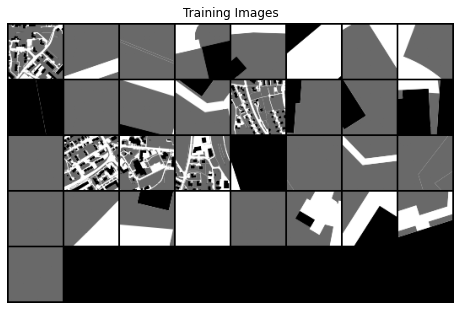

In [11]:
# We can use an image folder dataset the way we have it setup.
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               # transforms.Resize(image_size*4),
                               transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [12]:
dataset

Dataset ImageFolder
    Number of datapoints: 33
    Root location: ../data/cadastralExport
    StandardTransform
Transform: Compose(
               RandomCrop(size=(64, 64), padding=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
len(real_batch[0])

33

In [166]:
real_batch[0].size()

torch.Size([21, 3, 64, 64])

In [157]:
datasetTest = dset.ImageFolder(root=datarootTest,
                               transform=transforms.Compose([
                               transforms.Resize(image_size*4),
                               transforms.RandomCrop(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloaderTest = torch.utils.data.DataLoader(datasetTest, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

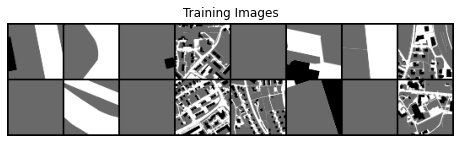

In [149]:
test_batch = next(iter(dataloaderTest))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)));

## 4. Weight Initialization

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # fills the weights? gamma param with normal distribution
        nn.init.constant_(m.bias.data, 0) # fills the bias with the constant 0

# 5. Generator Class

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz, h=1, w=1
            nn.ConvTranspose2d(in_channels=nz, #deconvolution!
                               out_channels=ngf * 8, 
                               kernel_size=4, 
                               stride=1, 
                               padding=0, 
                               bias=False), #no learnable bias 
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8, 
                               out_channels=ngf * 4, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 4), # accelerates the learning rate by 14 times
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4, 
                               out_channels=ngf * 2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2, 
                               out_channels=ngf, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, 
                               out_channels=nc, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.Sigmoid() # since the desired output are white (0), grey (0.5) or black (1) pixels
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(module=netG, devide_ids=list(range(ngpu))) # recommended to use DistributedDataParallel instead

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
class OptGen(nn.Module):
    def __init__(self, ngpu, num_conv_layers, drop_conv2):
        super(OptGen, self).__init__()
        self.ngpu = ngpu
        self.drop_conv2 = drop_conv2
        self.num_filters = [3] 
        self.num_filters.extend([2**(i+6) for i in range(num_conv_layers-1)])
        self.strides = [2]
        self.paddings = [1]
        self.kernelSizes = [4]
        self.out_size = []
        if num_conv_layers == 3:
            self.strides.extend([2,2])
            self.paddings.extend([0,0])
            self.kernelSizes.extend([14,10])
        if num_conv_layers == 4:
            self.strides.extend([2,2,2])
            self.paddings.extend([1,0,0])
            self.kernelSizes.extend([4,6,6])
        if num_conv_layers == 5:
            self.strides.extend([2,2,2,2])
            self.paddings.extend([1,1,1,0])
            self.kernelSizes.extend([4,4,4,4])
        if num_conv_layers == 6:
            self.strides.extend([2,2,2,2,2])
            self.paddings.extend([1,1,1,1,1])
            self.kernelSizes.extend([4,4,4,4,4])
        # self.out_size = []
        # same scheme as for DNet, but inverted
        self.num_filters.reverse()
        self.strides.reverse()
        self.paddings.reverse()
        self.kernelSizes.reverse()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz, h=1, w=1
            # output size: (2**6) x 4 x 4 O=(I-1)*s+k-2p
            nn.ConvTranspose2d(in_channels=nz, #deconvolution!
                               out_channels=self.num_filters[0], #ngf * 8, 
                               kernel_size=self.kernelSizes[0], 
                               stride=self.strides[0], 
                               padding=self.paddings[0], 
                               bias=False), # (1-1)*1+4-2*0=4
            nn.BatchNorm2d(self.num_filters[0]),
            nn.ReLU(True)
        )
        self.out_size.append([self.num_filters[0], (1-1)*self.strides[0]+self.kernelSizes[0]-2*self.paddings[0]])
        self.num_modules = 3
        for i in range(1, num_conv_layers):
            self.main.add_module(str(4*i-1)+"): TransConv_"+str(i+1), nn.ConvTranspose2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            self.out_size.append([self.num_filters[i], (self.out_size[i-1][1]-1)*self.strides[i]+self.kernelSizes[i]-2*self.paddings[i]])
            self.num_modules += 1
            if i + 1 < num_conv_layers:
                self.main.add_module(str(4*i)+"): DropOut_" + str(i+1), nn.Dropout2d(p=self.drop_conv2))
                self.main.add_module(str(1+4*i)+"): BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(2+4*i)+"): ReLU_" + str(i+1), nn.ReLU(True))
                self.num_modules += 3
            
        self.main.add_module(str(self.num_modules), nn.Tanh())
        ## print(f"Progression of the sizes in the deconvolution: {self.out_size}")
    
    def forward(self, input):
        return self.main(input)

In [12]:
testGen = OptGen(1, 6, 0.4).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    testGen = nn.DataParallel(testGen, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
testGen.apply(weights_init)

print(testGen)

OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.4, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.4, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): DropOut_4): Dro

# 6. Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, 
                      out_channels=ndf * 2, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (32-4+2)/2+1=16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2, 
                      out_channels=ndf * 4, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(16-4+2)/2+1=8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4, 
                      out_channels=ndf * 8, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(8-4+2)/2+1=4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, 
                      out_channels=1, 
                      kernel_size=4, 
                      stride=1, 
                      padding=0, 
                      bias=False), #(4-4)/2+1=1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
class OptDis(nn.Module):
    def __init__(self, ngpu, num_conv_layers):
        super(OptDis, self).__init__()
        self.ngpu = ngpu
        self.num_filters = [2**(i+6) for i in range(num_conv_layers-1)]
        self.num_filters.append(1)
        self.strides = [2]
        self.paddings = [1]
        self.kernelSizes = [4]
        self.out_size = []
        if num_conv_layers == 3:
            self.strides.extend([2,2])
            self.paddings.extend([0,0])
            self.kernelSizes.extend([14,10])
        if num_conv_layers == 4:
            self.strides.extend([2,2,2])
            self.paddings.extend([1,0,0])
            self.kernelSizes.extend([4,6,6])
        if num_conv_layers == 5:
            self.strides.extend([2,2,2,2])
            self.paddings.extend([1,1,1,0])
            self.kernelSizes.extend([4,4,4,4])
        if num_conv_layers == 6:
            self.strides.extend([2,2,2,2,2])
            self.paddings.extend([1,1,1,1,1])
            self.kernelSizes.extend([4,4,4,4,4])
            
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64 -> output nc = 2**6 x 32 x 32
            nn.Conv2d(in_channels=nc, 
                      out_channels=self.num_filters[0], 
                      kernel_size=self.kernelSizes[0], 
                      stride=self.strides[0], 
                      padding=self.paddings[0], 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_conv_layers):
            # input is nc=(2**(i+5) x 32 x 32 -> output nc = 2**(i+6) x 32*2**(-i) x 32*2**(-i)
            self.main.add_module(str(3*i-1)+"): Conv_"+str(i+1), nn.Conv2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            if i + 1 < num_conv_layers: 
                self.main.add_module(str(3*i)+"): BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(1+3*i)+"): LeakyReLU_" + str(i+1), nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.main.add_module(str(3*i)+"): Sigmoid", nn.Sigmoid())
    
    def forward(self, input):
        return self.main(input)

In [15]:
netD = OptDis(1, 5).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(test1, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

print(netD)

OptDis(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv_3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU_3): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv_4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm_4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU_4): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv_5): Conv2

In [16]:
real_cpu = test_batch[0].to(device)
b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
label = torch.full((b_size,), 1, dtype=torch.float, device=device) # size, fill value
# Forward pass real batch through D
output = netD(real_cpu).view(-1)

           ### netD.zero_grad() # sets all gradients to 0
           ### # Format batch
           ### real_cpu = data[0].to(device)
           ### b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
           ### label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # size, fill value
           ### # Forward pass real batch through D
           ### output = netD(real_cpu).view(-1)

# 7. Hyperparam Tuning

In [42]:
# Initialize BCELoss function
criterion = nn.BCELoss() #binary cross entropy, adapt for a probability output and for sigmoid function in D

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
img_list = []
G_losses = []
D_losses = []

In [43]:
def train(netG, netD, device, dataloader, optimizerG, optimizerD, epochs):
    
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad() # sets all gradients to 0
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # size, fill value
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # print(f"size of the batch: {b_size}")
            # print(f"size of the output: {output.shape}")
            # print(f"size of the labels: {label.shape}")
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

In [44]:
drop_conv2 = random.uniform(0.2,0.5)

In [45]:
netD = OptDis(ngpu, num_conv_layers=3).to(device)
netG = OptGen(ngpu, num_conv_layers=4, drop_conv2=drop_conv2).to(device)

In [46]:
train(netG, netD, device, dataloader, optimizerG, optimizerD, epochs=300)

Starting Training Loop...
[0/50][0/1]	Loss_D: 1.3559	Loss_G: 0.7687	D(x): 0.5044	D(G(z)): 0.4740 / 0.4740
[1/50][0/1]	Loss_D: 1.3709	Loss_G: 0.7514	D(x): 0.4990	D(G(z)): 0.4793 / 0.4793
[2/50][0/1]	Loss_D: 1.4120	Loss_G: 0.7523	D(x): 0.4907	D(G(z)): 0.4838 / 0.4838
[3/50][0/1]	Loss_D: 1.3881	Loss_G: 0.7560	D(x): 0.4836	D(G(z)): 0.4755 / 0.4755
[4/50][0/1]	Loss_D: 1.3893	Loss_G: 0.7303	D(x): 0.4961	D(G(z)): 0.4874 / 0.4874
[5/50][0/1]	Loss_D: 1.4687	Loss_G: 0.6965	D(x): 0.4778	D(G(z)): 0.5045 / 0.5045
[6/50][0/1]	Loss_D: 1.3658	Loss_G: 0.8165	D(x): 0.4877	D(G(z)): 0.4569 / 0.4569
[7/50][0/1]	Loss_D: 1.3588	Loss_G: 0.7821	D(x): 0.4964	D(G(z)): 0.4690 / 0.4690
[8/50][0/1]	Loss_D: 1.3176	Loss_G: 0.7904	D(x): 0.5001	D(G(z)): 0.4582 / 0.4582
[9/50][0/1]	Loss_D: 1.3789	Loss_G: 0.7696	D(x): 0.4844	D(G(z)): 0.4692 / 0.4692
[10/50][0/1]	Loss_D: 1.3708	Loss_G: 0.7779	D(x): 0.4894	D(G(z)): 0.4683 / 0.4683
[11/50][0/1]	Loss_D: 1.4014	Loss_G: 0.7532	D(x): 0.4751	D(G(z)): 0.4747 / 0.4747
[12/50][0/1]

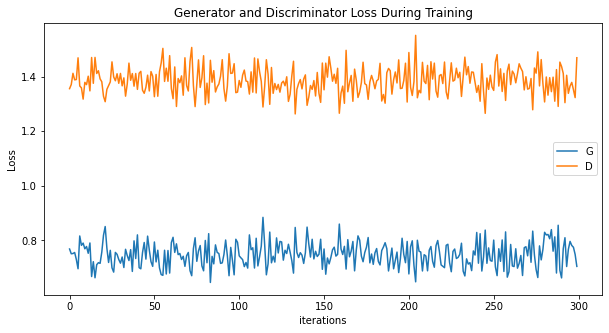

In [47]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

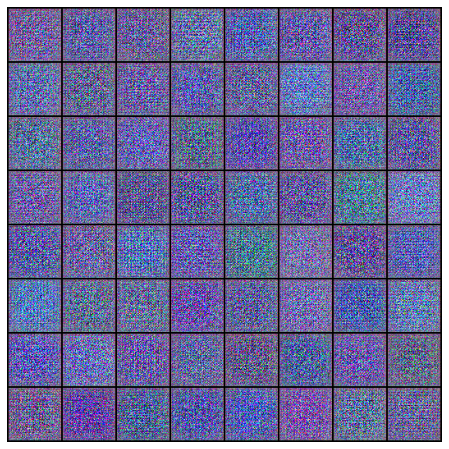

In [48]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [60]:
def test(netG, device, dataloader):
    nz_dim = nz
    errG = []
    for i, data in enumerate(dataloader, 0):
        real = data[0].to(device)
        # batch_size, seq_len = real.size(0), real.size(1)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        mse = nn.MSELoss()
        with torch.no_grad():
            fake = netG(noise)
            ## print(f"dimensions for the fake tensor: {fake.shape}")
            errG += [mse(fake, real)]
    v = torch.tensor(errG).float().mean().item()
    ## print(f"mse_errG: {v}")
    return v

In [61]:
def suggest_hyperparameters(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    ## dropoutG = trial.suggest_float("dropoutG", 0.0, 0.4, step=0.1)
    ## dropoutD = trial.suggest_float("dropoutD", 0.0, 0.4, step=0.1)
    # optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "Adadelta"])
    convsG = trial.suggest_int("convsG", 3, 6, step=1)
    convsD = trial.suggest_int("convsD", 3, 6, step=1)
    drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)
    return lr, weight_decay, convsG, convsD, drop_conv2 #lr, optimizer_name, dropoutG, dropoutD

In [62]:
def objective(trial: optuna.Trial):
    best_val_loss = float('Inf')
    nz_dim = nz
    best_mse_val = None
    
    # full_dataset = next(iter(dataloader)) # DatasetLoader("data.csv")
    # train_size = int(0.8 * len(full_dataset[0]))
    # test_size = len(full_dataset[0]) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    with mlflow.start_run():

        lr, weight_decay, convsG, convsD, drop_conv2 = suggest_hyperparameters(trial)
        n_epochs = 2 #1000
        torch.manual_seed(123)
        mlflow.log_params(trial.params)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)
        
        # train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
        # test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=True)

        # netG = Generator(in_dim=nz_dim, n_channel=10, kernel_size=8, out_dim=1, hidden_dim=100, dropout=dropoutG).to(device)
        # netD = Discriminator(in_dim=1, cnn_layers=4, n_layers=1, kernel_size=8, n_channel=10, dropout=dropoutD, hidden_dim=100).to(device)
        
        # netG = Generator(ngpu).to(device)
        # netD = Discriminator(ngpu).to(device)
        netD = OptDis(ngpu, convsD).to(device)
        netG = OptGen(ngpu, convsG, drop_conv2).to(device)
        
        netD.apply(weights_init)
        netG.apply(weights_init)
        
        optimizerD = getattr(optim, 'Adam')(netD.parameters(), lr=lr, weight_decay=weight_decay)
        optimizerG = getattr(optim, 'Adam')(netG.parameters(), lr=lr, weight_decay=weight_decay)
        ###########
        ## print(f"Convolutions for D: {convsD}")
        ## print(f"Convolutions for G: {convsG}")
        ##########
        
        train(netG, netD, device, dataloader, optimizerG, optimizerD, n_epochs)
        ##########
        ## print(netG)
        ## print(device)
        ## print(dataloaderTest)
        mse_errG = test(netG, device, dataloaderTest)
        
        if best_mse_val is None:
            best_mse_val = mse_errG
        if mse_errG <= best_mse_val:
            # LOGGING
            logging.debug('*'*40)
            logging.debug(f'Optuna Params: {trial.params}')
            logging.debug(f'Mean Square Error Loss: {mse_errG}') 
            # Save Models
            torch.save(netG, "../models/MVPBestGenerator")
            torch.save(netD, "../models/MVPBestDiscriminator")
        best_mse_val = min(best_mse_val, mse_errG)
        mlflow.log_metric("mse_errG", mse_errG)

    return best_mse_val

In [63]:
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M")

experiment_id = mlflow.create_experiment(
    f"../reports/TSGAN_Exp_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"TSGAN_study_{run_tag}", direction="minimize")
study.optimize(objective, n_trials=5)

[I 2023-03-26 20:00:09,008] A new study created in memory with name: TSGAN_study_2023-03-26T20:00


Starting Training Loop...
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[0/50][0/1]	Loss_D: 1.8527	Loss_G: 2.7928	D(x): 0.4268	D(G(z)): 0.5045 / 0.4917
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[1/50][0/1]	Loss_D: 22.1142	Loss_G: 51.6889	D(x): 0.7989	D(G(z)): 0.9994 / 0.0000


[I 2023-03-26 20:00:10,393] Trial 0 finished with value: 1.0196951627731323 and parameters: {'lr': 0.04486328903426791, 'weight_decay': 1.3210875206324926e-07, 'convsG': 5, 'convsD': 4, 'drop_conv2': 0.48713723363090866}. Best is trial 0 with value: 1.0196951627731323.


Starting Training Loop...
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[0/50][0/1]	Loss_D: 1.8882	Loss_G: 29.2892	D(x): 0.4621	D(G(z)): 0.5392 / 0.0000
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[1/50][0/1]	Loss_D: 5.7385	Loss_G: 30.5887	D(x): 0.6706	D(G(z)): 0.5446 / 0.0000


[I 2023-03-26 20:00:11,707] Trial 1 finished with value: 0.5817440748214722 and parameters: {'lr': 0.013382385578544452, 'weight_decay': 0.0005758085309277622, 'convsG': 4, 'convsD': 4, 'drop_conv2': 0.34560320101910424}. Best is trial 1 with value: 0.5817440748214722.


Starting Training Loop...
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[0/50][0/1]	Loss_D: 1.2020	Loss_G: 4.4951	D(x): 0.5746	D(G(z)): 0.4436 / 0.0128
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[1/50][0/1]	Loss_D: 0.8829	Loss_G: 3.4743	D(x): 0.6642	D(G(z)): 0.2455 / 0.0331


[I 2023-03-26 20:00:13,324] Trial 2 finished with value: 0.47089260816574097 and parameters: {'lr': 0.00010136469362239283, 'weight_decay': 5.739050824595622e-07, 'convsG': 3, 'convsD': 6, 'drop_conv2': 0.31591698444940886}. Best is trial 2 with value: 0.47089260816574097.


Starting Training Loop...
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[0/50][0/1]	Loss_D: 1.9848	Loss_G: 42.3251	D(x): 0.5534	D(G(z)): 0.6282 / 0.0000
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[1/50][0/1]	Loss_D: 9.7834	Loss_G: 13.4561	D(x): 0.4069	D(G(z)): 0.0000 / 0.2429


[I 2023-03-26 20:00:14,725] Trial 3 finished with value: 0.5403172969818115 and parameters: {'lr': 0.004368477067704528, 'weight_decay': 3.803725778844947e-08, 'convsG': 5, 'convsD': 5, 'drop_conv2': 0.3028224525040933}. Best is trial 2 with value: 0.47089260816574097.


Starting Training Loop...
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[0/50][0/1]	Loss_D: 1.8622	Loss_G: 3.0588	D(x): 0.6026	D(G(z)): 0.6446 / 0.0535
size of the batch: 14
size of the output: torch.Size([14])
size of the labels: torch.Size([14])
[1/50][0/1]	Loss_D: 1.0466	Loss_G: 2.9986	D(x): 0.6587	D(G(z)): 0.3640 / 0.0630


[I 2023-03-26 20:00:16,059] Trial 4 finished with value: 0.40198248624801636 and parameters: {'lr': 0.00010003246453263082, 'weight_decay': 1.41757004963206e-08, 'convsG': 4, 'convsD': 5, 'drop_conv2': 0.37495286489369783}. Best is trial 4 with value: 0.40198248624801636.


## 99. ARCHIVE - Define Optimisation Classes for Generator

Furio's Comment: 

in original GANs there are two metrics to optimize, the generator and the discriminator loss

In the optimisation example (https://github.com/elena-ecn/optuna-optimization-for-PyTorch-CNN/blob/main/optuna_optimization.py) there is a single model that is optimized for accuracy. 
My hypothesis is that in optuna both of the models need to be considered in the optimisation.

<b>About the layer Structure:</b> </br>
we need in any case transposed Convolutions till
the desired output size (64x64) is achieved.
Therefore I'm starting with the same layers as in the original example. On top of it it is possible to add one or more extra transposed convolutions that do not influence the size

In [ ]:
###class Generator(nn.Module):
###    """CNN for the MNIST dataset of handwritten digits.
###    Attributes:
###        - convs (torch.nn.modules.container.ModuleList):   List with the convolutional layers
###        - conv2_drop (torch.nn.modules.dropout.Dropout2d): Dropout for conv layer 2
###        - out_feature (int):                               Size of flattened features
###        - fc1 (torch.nn.modules.linear.Linear):            Fully Connected layer 1
###        - fc2 (torch.nn.modules.linear.Linear):            Fully Connected layer 2
###        - p1 (float):                                      Dropout ratio for FC1
###    Methods:
###        - forward(x): Does forward propagation
###    """
###    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1):
###        """Parameters:
###            - trial (optuna.trial._trial.Trial): Optuna trial
###            - num_conv_layers (int):             Number of convolutional layers
###            - num_filters (list):                Number of filters of conv layers
###            - num_neurons (int):                 Number of neurons of FC layers
###            - drop_conv2 (float):                Dropout ratio for conv layer 2
###            - drop_fc1 (float):                  Dropout ratio for FC1
###        """
###        super(Generator, self).__init__()                                               # Initialize parent class
###        in_size = nz                                                                    # Input noise size
###        ksize = 4                                                                       # Convolution filter size
###        stride = 2
###        padding = 1
###
###        # Define the convolutional layers
###        self.convs = nn.ModuleList([nn.ConvTranspose2d(1, num_filters[0], 
###                                                       kernel_size=ksize,
###                                                       stride=stride,
###                                                       padding=padding)])               # List with the Conv layers
###        out_size = int((in_size - ksize + 2 * padding) / stride) + 1                    # Size of the output kernel
###        # out_size = int(out_size / 2)                                                  # Size after pooling
###        
###        
###        
###        
###        for i in range(1, num_conv_layers):
###            self.convs.append(nn.ConvTranspose2d(in_channels=num_filters[i-1], out_channels=num_filters[i], 
###                                                 kernel_size=ksize, stride = stride, padding=padding,
###                                                 bias=False))
###            out_size = int((in_size - ksize + 2 * padding) / stride) + 1                # Size of the output kernel
###            # out_size = int(out_size/2)                                                # Size after pooling
###            
###
###        self.conv2_drop = nn.Dropout2d(p=drop_conv2)                                    # Dropout for conv2
###        self.out_feature = num_filters[num_conv_layers-1] * out_size * out_size         # Size of flattened features
###        self.fc1 = nn.Linear(self.out_feature, num_neurons)                             # Fully Connected layer 1
###        self.fc2 = nn.Linear(num_neurons, 10)                                           # Fully Connected layer 2
###        self.p1 = drop_fc1                                                              # Dropout ratio for FC1
###
###        # Initialize weights with the He initialization
###        for i in range(1, num_conv_layers):
###            nn.init.kaiming_normal_(self.convs[i].weight, nonlinearity='relu')
###            if self.convs[i].bias is not None:
###                nn.init.constant_(self.convs[i].bias, 0)
###        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
###
###    def forward(self, x):
###        """Forward propagation.
###        Parameters:
###            - x (torch.Tensor): Input tensor of size [N,1,28,28]
###        Returns:
###            - (torch.Tensor): The output tensor after forward propagation [N,10]
###        """
###        for i, conv_i in enumerate(self.convs):  # For each convolutional layer
###            if i == 2:  # Add dropout if layer 2
###                x = F.relu(F.max_pool2d(self.conv2_drop(conv_i(x)), 2))  # Conv_i, dropout, max-pooling, RelU
###            else:
###                x = F.relu(F.max_pool2d(conv_i(x), 2))                   # Conv_i, max-pooling, RelU
###
###        x = x.view(-1, self.out_feature)                     # Flatten tensor
###        x = F.relu(self.fc1(x))                              # FC1, RelU
###        x = F.dropout(x, p=self.p1, training=self.training)  # Apply dropout after FC1 only when training
###        x = self.fc2(x)                                      # FC2
###
###        return F.log_softmax(x, dim=1)                       # log(softmax(x))
###
###
###    def train(network, optimizer):
###        """Trains the model.
###        Parameters:
###            - network (__main__.Net):              The CNN
###            - optimizer (torch.optim.<optimizer>): The optimizer for the CNN
###        """
###        network.train()  # Set the module in training mode (only affects certain modules)
###        for batch_i, (data, target) in enumerate(train_loader):  # For each batch
###
###            # Limit training data for faster computation
###            if batch_i * batch_size_train > number_of_train_examples:
###                break
###
###            optimizer.zero_grad()                                 # Clear gradients
###            output = network(data.to(device))                     # Forward propagation
###            loss = F.nll_loss(output, target.to(device))          # Compute loss (negative log likelihood: −log(y))
###            loss.backward()                                       # Compute gradients
###            optimizer.step()                                      # Update weights
###
###
###    def test(network):
###        """Tests the model.
###        Parameters:
###            - network (__main__.Net): The CNN
###        Returns:
###            - accuracy_test (torch.Tensor): The test accuracy
###        """
###        network.eval()         # Set the module in evaluation mode (only affects certain modules)
###        correct = 0
###        with torch.no_grad():  # Disable gradient calculation (when you are sure that you will not call Tensor.backward())
###            for batch_i, (data, target) in enumerate(test_loader):  # For each batch
###
###                # Limit testing data for faster computation
###                if batch_i * batch_size_test > number_of_test_examples:
###                    break
###
###                output = network(data.to(device))               # Forward propagation
###                pred = output.data.max(1, keepdim=True)[1]      # Find max value in each row, return indexes of max values
###                correct += pred.eq(target.to(device).data.view_as(pred)).sum()  # Compute correct predictions
###
###        accuracy_test = correct / len(test_loader.dataset)
###
###        return accuracy_test
###
###
###    def objective(trial):
###        """Objective function to be optimized by Optuna.
###        Hyperparameters chosen to be optimized: optimizer, learning rate,
###        dropout values, number of convolutional layers, number of filters of
###        convolutional layers, number of neurons of fully connected layers.
###        Inputs:
###            - trial (optuna.trial._trial.Trial): Optuna trial
###        Returns:
###            - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
###        """
###
###        # Define range of values to be tested for the hyperparameters
###        num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)  # Number of convolutional layers
###        num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
###                       for i in range(num_conv_layers)]              # Number of filters for the convolutional layers
###        num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of FC1 layer
###        drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)     # Dropout for convolutional layer 2
###        drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)         # Dropout for FC1 layer
###
###        # Generate the model
###        model = Generator(trial, num_conv_layers, num_filters, num_neurons, drop_conv2,  drop_fc1).to(device)
###
###        # Generate the optimizers
###        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])  # Optimizers
###        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)                                 # Learning rates
###        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
###
###        # Training of the model
###        for epoch in range(n_epochs):
###            train(model, optimizer)  # Train the model
###            accuracy = test(model)   # Evaluate the model
###
###            # For pruning (stops trial early if not promising)
###            trial.report(accuracy, epoch)
###            # Handle pruning based on the intermediate value.
###            if trial.should_prune():
###                raise optuna.exceptions.TrialPruned()
###
###        return accuracy

In [ ]:
### # -------------------------------------------------------------------------
### # Optimization study for a PyTorch CNN with Optuna
### # -------------------------------------------------------------------------
### 
### # Use cuda if available for faster computations
### device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
### 
### # --- Parameters ----------------------------------------------------------
### n_epochs = 10                         # Number of training epochs
### batch_size_train = 64                 # Batch size for training data
### batch_size_test = 1000                # Batch size for testing data
### number_of_trials = 100                # Number of Optuna trials
### limit_obs = True                      # Limit number of observations for faster computation
### 
### # *** Note: For more accurate results, do not limit the observations.
### #           If not limited, however, it might take a very long time to run.
### #           Another option is to limit the number of epochs. ***
### 
### if limit_obs:  # Limit number of observations
###     number_of_train_examples = 500 * batch_size_train  # Max train observations
###     number_of_test_examples = 5 * batch_size_test      # Max test observations
### else:
###     number_of_train_examples = 60000                   # Max train observations
###     number_of_test_examples = 10000                    # Max test observations
### # -------------------------------------------------------------------------
### 
### # Make runs repeatable
### random_seed = 1
### torch.backends.cudnn.enabled = False  # Disable cuDNN use of nondeterministic algorithms
### torch.manual_seed(random_seed)
### 
### # Create directory 'files', if it doesn't exist, to save the dataset
### directory_name = 'files'
### if not os.path.exists(directory_name):
###     os.mkdir(directory_name)
### 
### # Download MNIST dataset to 'files' directory and normalize it
### ## train_loader = torch.utils.data.DataLoader(
### ##     torchvision.datasets.MNIST('/files/', train=True, download=True,
### ##                                transform=torchvision.transforms.Compose([
### ##                                    torchvision.transforms.ToTensor(),
### ##                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
### ##     batch_size=batch_size_train, shuffle=True)
### ## 
### ## test_loader = torch.utils.data.DataLoader(
### ##     torchvision.datasets.MNIST('/files/', train=False, download=True,
### ##                                transform=torchvision.transforms.Compose([
### ##                                    torchvision.transforms.ToTensor(),
### ##                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
### ##     batch_size=batch_size_test, shuffle=True)
### 
### # Create an Optuna study to maximize test accuracy
### study = optuna.create_study(direction="maximize")
### study.optimize(objective, n_trials=number_of_trials)
### 
### # -------------------------------------------------------------------------
### # Results
### # -------------------------------------------------------------------------
### 
### # Find number of pruned and completed trials
### pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
### complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
### 
### # Display the study statistics
### print("\nStudy statistics: ")
### print("  Number of finished trials: ", len(study.trials))
### print("  Number of pruned trials: ", len(pruned_trials))
### print("  Number of complete trials: ", len(complete_trials))
### 
### trial = study.best_trial
### print("Best trial:")
### print("  Value: ", trial.value)
### print("  Params: ")
### for key, value in trial.params.items():
###     print("    {}: {}".format(key, value))
### 
### # Save results to csv file
### df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
### df = df.loc[df['state'] == 'COMPLETE']        # Keep only results that did not prune
### df = df.drop('state', axis=1)                 # Exclude state column
### df = df.sort_values('value')                  # Sort based on accuracy
### df.to_csv('optuna_results.csv', index=False)  # Save to csv file
### 
### # Display results in a dataframe
### print("\nOverall Results (ordered by accuracy):\n {}".format(df))
### 
### # Find the most important hyperparameters
### most_important_parameters = optuna.importance.get_param_importances(study, target=None)
### 
### # Display the most important hyperparameters
### print('\nMost important hyperparameters:')
### for key, value in most_important_parameters.items():
###     print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))